# Implementation of a comparison of Split and uncalibrated scenarion

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import multiprocessing as mp
from src.util import sigmoid
from src.feature_map import IdentityFeatureMap
from src.functions import cost_utility, demographic_parity
from src.plotting import plot_mean, plot_median
from src.training import train
from src.distribution import SplitDistribution, UncalibratedScore

In [2]:
def fairness_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]
    numerator, denominator_log_grad = policy._log_gradient(x, s)

    benefit = policy.benefit_function(decisions=decisions, y=y)
    benefit_gradient = benefit / denominator_log_grad

    if ips_weights is not None:
        benefit *= ips_weights
        benefit_gradient *= ips_weights

    benefit_grad = numerator * benefit_gradient
        
    # benefit-difference * grad-benefit-difference
    return policy._mean_difference(benefit, s) * policy._mean_difference(benefit_grad, s)

## Uncalibrated Score

In [3]:
bias = True
dim_x = 1
dim_theta = dim_x + 1 if bias else dim_x

def util_func(**util_params):
    util = cost_utility(cost_factor=0.142, **util_params)
    return util

training_parameters = {    
    'model':{
        'theta': [-3.0, 5.0],
        'benefit_function': demographic_parity,
        'utility_function': util_func,
        'fairness_function': fairness_function,
        'feature_map': IdentityFeatureMap(dim_theta),
        'keep_collected_data': False,
        'use_sensitve_attributes': False,
        'bias': bias
    },
    'optimization': {
        'time_steps':200,
        'epochs': 1,
        'batch_size':256,
        'learning_rate': 1,
        'decay_rate': 1,
        'decay_step': 10000
    },
    'data': {
        'distribution': UncalibratedScore(bias=bias),
        'fraction_protected':0.5,
        'num_test_samples': 8192,
        'num_decisions': 128 * 256
    }
}


Processing Lambda 0.0 


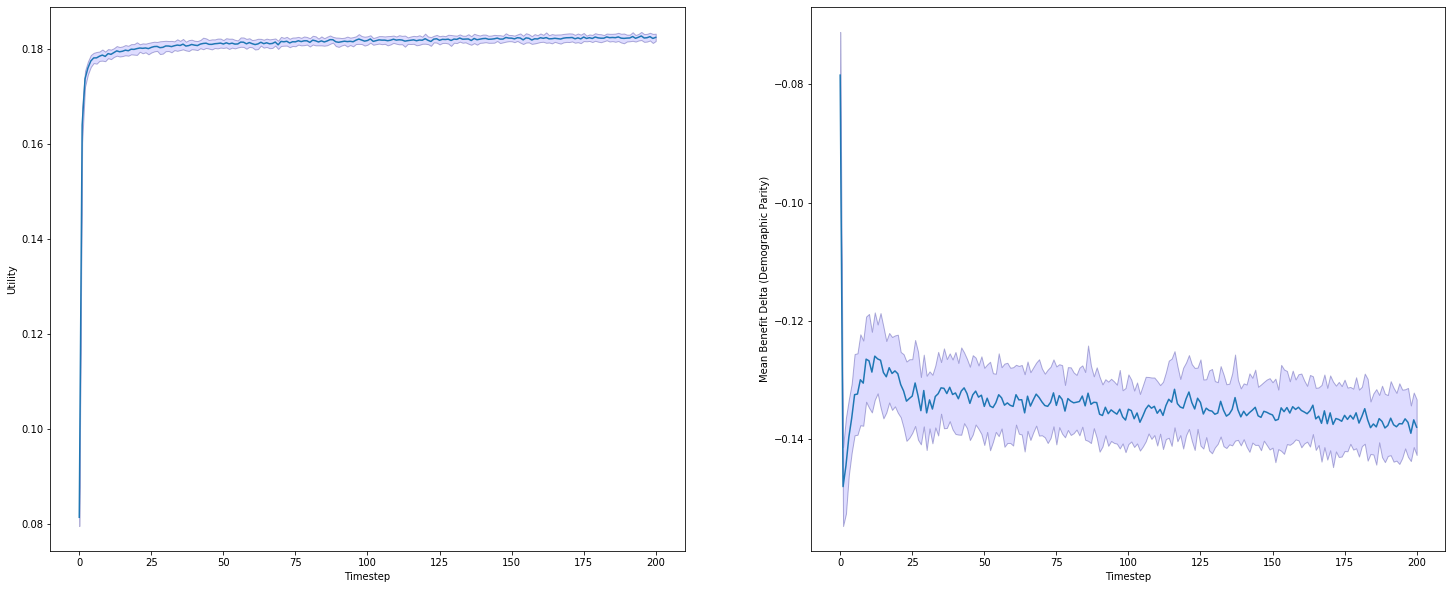

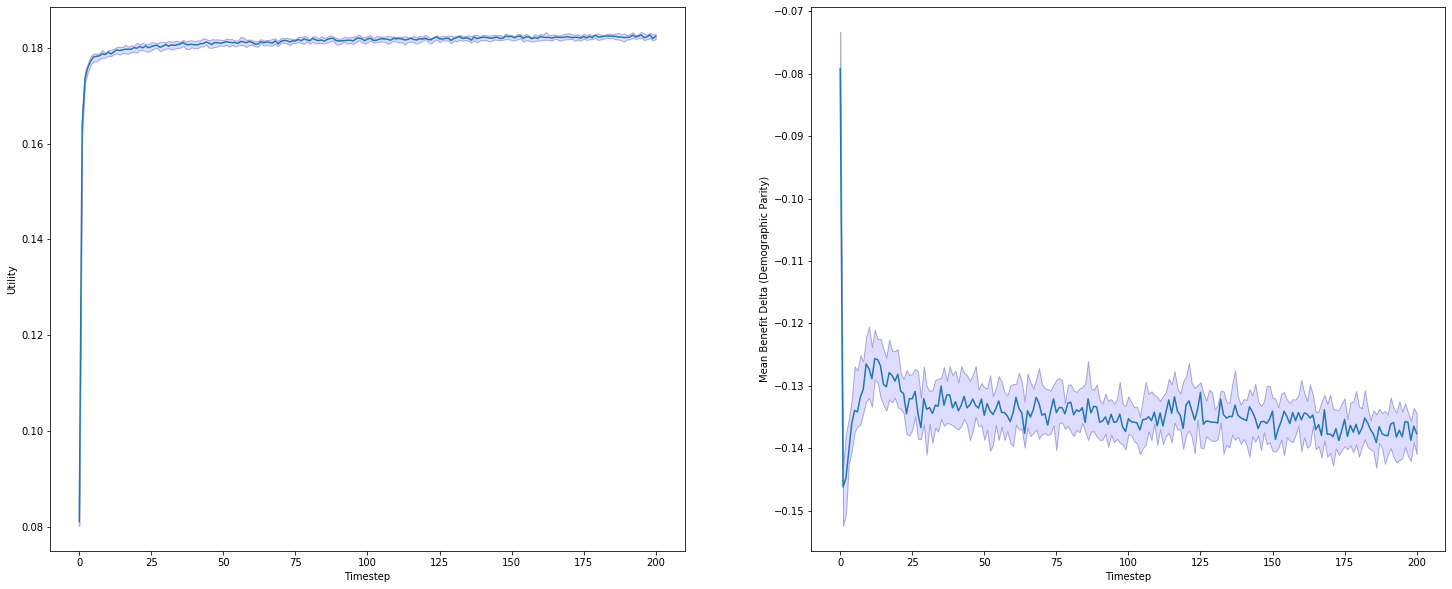

In [4]:
training_parameters["save_path"] = "/home/fkretschmar/Documents/master-thesis/res/exp-009/uncalibrated/time"
statistics, run_path = train(training_parameters, fairness_rates=[0.0], iterations=30, asynchronous=True)

plot_mean(statistics, "{}/results_mean_time.png".format(run_path))
plot_median(statistics, "{}/results_median_time.png".format(run_path))

Processing Lambda 0.0 
Processing Lambda 0.01 
Processing Lambda 0.014677992676220698 
Processing Lambda 0.021544346900318832 
Processing Lambda 0.03162277660168379 
Processing Lambda 0.046415888336127774 
Processing Lambda 0.06812920690579612 
Processing Lambda 0.1 
Processing Lambda 0.1467799267622069 
Processing Lambda 0.21544346900318834 
Processing Lambda 0.31622776601683794 
Processing Lambda 0.46415888336127775 
Processing Lambda 0.6812920690579611 
Processing Lambda 1.0 
Processing Lambda 1.467799267622069 
Processing Lambda 2.154434690031882 
Processing Lambda 3.1622776601683795 
Processing Lambda 4.6415888336127775 
Processing Lambda 6.812920690579608 
Processing Lambda 10.0 


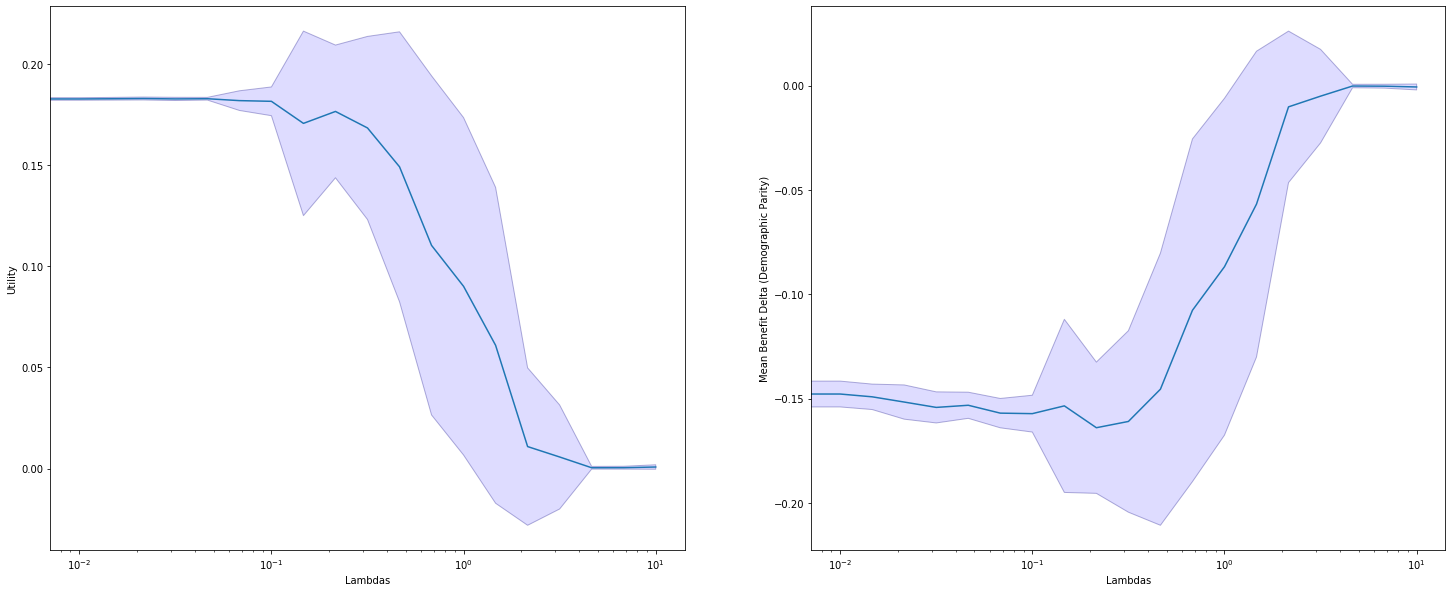

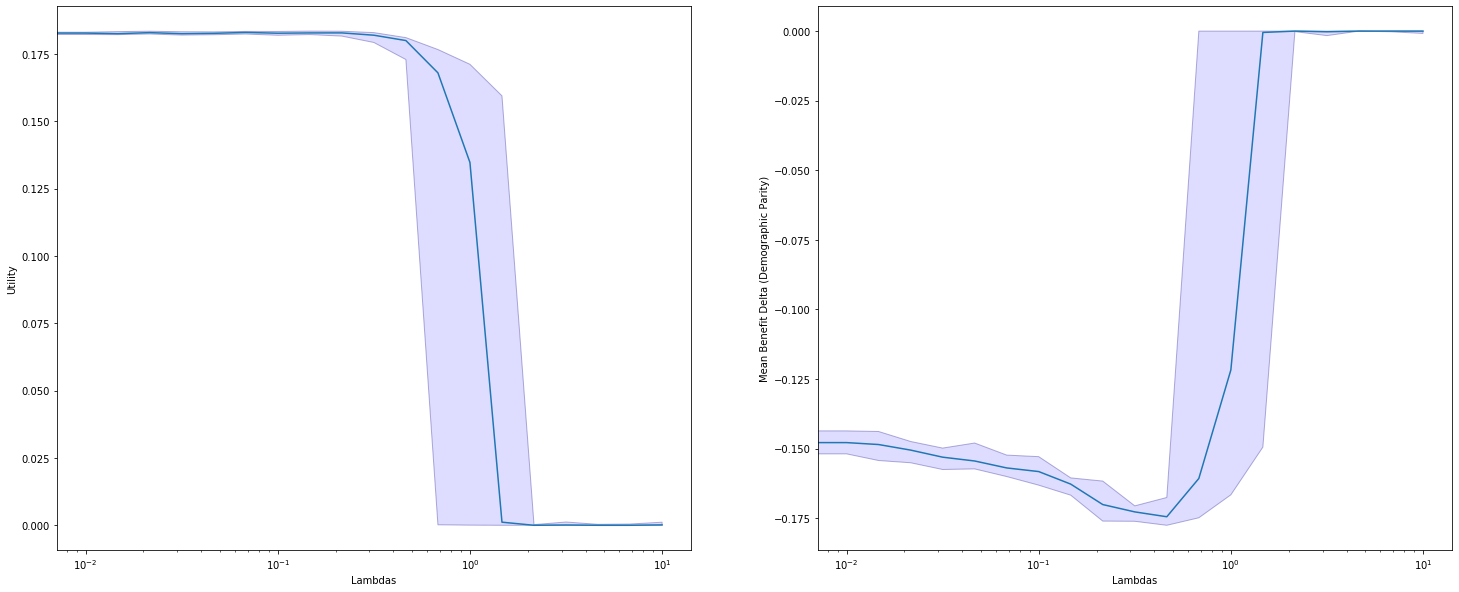

In [5]:
training_parameters["save_path"] = "/home/fkretschmar/Documents/master-thesis/res/exp-009/uncalibrated/lambda"
lambdas = np.logspace(-2, 1, base=10, endpoint=True, num=19)
lambdas = np.insert(arr=lambdas, obj=0, values=[0.0])

statistics, run_path = train(training_parameters, fairness_rates=lambdas, iterations=30, asynchronous=True)

plot_mean(statistics, "{}/results_mean_lambdas.png".format(run_path))
plot_median(statistics, "{}/results_median_lambdas.png".format(run_path))

## Split Distribution

In [9]:
bias = True
dim_x = 1
dim_theta = dim_x + 1 if bias else dim_x

def util_func(**util_params):
    util = cost_utility(cost_factor=0.55, **util_params)
    return util

training_parameters = {    
    'model':{
        'theta': [-3.5, 0.6],
        'benefit_function': demographic_parity,
        'utility_function': util_func,
        'fairness_function': fairness_function,
        'feature_map': IdentityFeatureMap(dim_theta),
        'keep_collected_data': False,
        'use_sensitve_attributes': False,
        'bias': bias
    },
    'optimization': {
        'time_steps':200,
        'epochs': 32,
        'batch_size':512,
        'learning_rate': 0.5,
        'decay_rate': 0.8,
        'decay_step': 30,
        'test_at_every_timestep': False
    },
    'data': {
        'distribution': SplitDistribution(bias=bias),
        'fraction_protected':0.5,
        'num_test_samples': 20480,
        'num_decisions': 32 * 512
    }
}

In [10]:
training_parameters["save_path"] = "/home/fkretschmar/Documents/master-thesis/res/exp-009/split/time"
statistics, run_path = train(training_parameters, fairness_rates=[0.0], iterations=30, asynchronous=True)

plot_mean(statistics, "{}/results_mean.png".format(run_path))
plot_median(statistics, "{}/results_median.png".format(run_path))

Processing Lambda 0.0 


In [0]:
training_parameters["save_path"] = "/home/fkretschmar/Documents/master-thesis/res/exp-009/split/lambda"
lambdas = np.logspace(-1, 2, base=10, endpoint=True, num=19)
lambdas = np.insert(arr=lambdas, obj=0, values=[0.0])

statistics, run_path = train(training_parameters, fairness_rates=lambdas, iterations=30, asynchronous=True)

plot_mean(statistics, "{}/results_mean_lambdas.png".format(run_path))
plot_median(statistics, "{}/results_median_lambdas.png".format(run_path))